In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Tools import portfolio_metrics, min_cost_partition, get_qubo, normalized_cost

In [2]:
# Number of Qubits 
N=12
# Number of excitations
k=6
# RNG seed for reproducibility
seed=1
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.1
# Nr. of layer repetitions
layers=5
# Maximal number of iterations for classical solver
max_iter=125

# Using grid Nearest neighbors
w_grid = True
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = False
# Distributing the 'k' excitations according to some strategy (other than just k first)
w_strategy = True
# Using extra z-phase term
w_z_phase = False



In [3]:
# Generating grid
if w_grid:
    my_grid = Grid(Rows=3, Cols=4)
    print(f' Qubit indices in grid: \n', my_grid.get_grid_indexing())
    print(f'\n Corresponding Nearest Neighbor index pairs: \n', my_grid.get_NN_indices())
    init_strat = np.array([[0,1,0,1],
                           [1,0,1,0],
                           [0,1,0,1]])
    my_grid.set_initialization_strategy(strategy=init_strat)
    print(f'\n Initialization strategy is: \n', my_grid.get_initialization_strategy())
    print(f'\n Corresponding indices is: \n', my_grid.get_initialization_indices())
    

 Qubit indices in grid: 
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]

 Corresponding Nearest Neighbor index pairs: 
 [(0, 4), (0, 1), (1, 5), (1, 2), (2, 6), (2, 3), (3, 7), (4, 8), (4, 5), (5, 9), (5, 6), (6, 10), (6, 7), (7, 11), (8, 9), (9, 10), (10, 11)]

 Initialization strategy is: 
 [[0 1 0 1]
 [1 0 1 0]
 [0 1 0 1]]

 Corresponding indices is: 
 [1, 3, 4, 6, 9, 11]


In [4]:
# Generating random problem instance 
expected_returns, covariances = portfolio_metrics(n=N, seed=seed)

# Retrieving C_min, C_max and corresponding states.
constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                            k=k,
                                                            mu=expected_returns,
                                                            sigma=covariances,
                                                            alpha=alpha)

max_cost, min_cost, min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
min_state_str = ''.join([str(_) for _ in min_state])

# Generating QUBO corresponding to current problem instance
Q, offset = get_qubo(mu=expected_returns,
                     sigma=covariances,
                     alpha=alpha,
                     lmbda=lmbda,
                     k=k)
print("Optimal state is: |"+min_state_str+">")

Optimal state is: |110100000111>


In [5]:
# Generating instances of ansatz'
CP_ansatz = CP_QAOA(N_qubits=N,
                 cardinality=k,
                 layers=layers,
                 grid=my_grid if w_grid else None,
                 QUBO_matrix=Q,
                 with_next_nearest_neighbors=w_next_nearest_neighbors,
                 with_z_phase=w_z_phase)

NORMAL_ansatz = QAOA(N_qubits=N,
                     layers=layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset)

In [6]:
# Generating initial guess for rotation angles for CP_ansatz
theta_min, theta_max = -2*np.pi, 2*np.pi
if w_grid:
    N_angles = layers * len(my_grid.get_NN_indices())
else:
    N_angles = layers * (N - 1) 
if w_next_nearest_neighbors:
    N_angles += layers * (N - 2)
if w_z_phase:
    N_angles += layers * N
theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)

# Choosing optimizer for scipy
available_methods = ['COBYLA', 'Nelder-Mead']
optimizer_method = available_methods[0]

# Generating callback function for plotting
costs = [] # Normalized costs
def callback_function(x):
    _dict_ = CP_ansatz.get_state_probabilities(angles=x, flip_states=False)
    _cost_ = normalized_cost(result=_dict_,
                             QUBO_matrix=Q,
                             QUBO_offset=offset,
                             max_cost=max_cost, 
                             min_cost=min_cost)
    costs.append(_cost_)


# Performing optimization
res = sc.optimize.minimize(fun=CP_ansatz.get_cost, x0=theta_i,
                           method=optimizer_method,
                           options={'disp': False, 'maxiter': max_iter},
                           callback=callback_function)

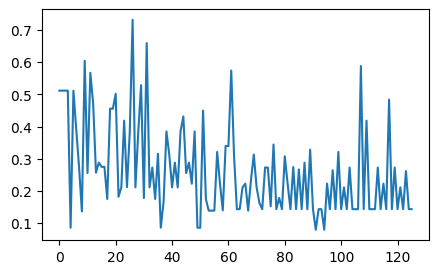

In [7]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot([it for it in range(len(costs))], costs)
plt.show()